# ANOVA Analysis: Between-User vs Within-User Variance

This notebook performs ANOVA to quantify whether between-user variance in valence and arousal is significantly larger than within-user variance.

**Analysis:**
- One-way ANOVA with user_id as grouping factor
- Separate analysis for valence and arousal
- Restricted to users with ≥ 5 samples
- Computes F-statistic, p-value, and η² (eta-squared) effect size
- Compares mean within-user variance vs mean between-user variance


In [5]:
# Install dependencies
%pip install pandas numpy scipy matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Set style (try seaborn-v0_8, fallback to seaborn if not available)
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        pass  # Use default style
sns.set_palette("husl")

# Create output directory
os.makedirs('plots', exist_ok=True)

# Load data
DATA_PATH = 'TRAIN_RELEASE_3SEP2025/train_subtask1.csv'
df = pd.read_csv(DATA_PATH)

print(f"Loaded {len(df)} samples")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"\nData columns: {df.columns.tolist()}")


Loaded 2764 samples
Unique users: 137

Data columns: ['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal']


## Data Filtering: Restrict to Users with ≥ 5 Samples


In [7]:
# Filter to users with ≥ 5 samples
user_counts = df['user_id'].value_counts()
valid_users = user_counts[user_counts >= 5].index
df_filtered = df[df['user_id'].isin(valid_users)].copy()

print(f"Original dataset: {len(df)} samples, {df['user_id'].nunique()} users")
print(f"Filtered dataset: {len(df_filtered)} samples, {df_filtered['user_id'].nunique()} users")
print(f"Minimum samples per user: {user_counts[user_counts >= 5].min()}")
print(f"Maximum samples per user: {user_counts[user_counts >= 5].max()}")
print(f"Mean samples per user: {user_counts[user_counts >= 5].mean():.2f}")


Original dataset: 2764 samples, 137 users
Filtered dataset: 2712 samples, 119 users
Minimum samples per user: 5
Maximum samples per user: 206
Mean samples per user: 22.79


## ANOVA Functions


In [8]:
def compute_eta_squared(ss_between, ss_total):
    """Compute eta-squared (η²) effect size."""
    return ss_between / ss_total if ss_total > 0 else 0.0

def perform_anova(df, target_col, group_col='user_id'):
    """
    Perform one-way ANOVA and compute variance components.
    
    Returns:
        dict with F-statistic, p-value, eta-squared, and variance components
    """
    # Get groups
    groups = [group[target_col].values for name, group in df.groupby(group_col)]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Compute sum of squares for eta-squared
    grand_mean = df[target_col].mean()
    ss_total = ((df[target_col] - grand_mean) ** 2).sum()
    
    # Between-group sum of squares
    ss_between = 0
    for name, group in df.groupby(group_col):
        n = len(group)
        group_mean = group[target_col].mean()
        ss_between += n * (group_mean - grand_mean) ** 2
    
    # Within-group sum of squares
    ss_within = 0
    for name, group in df.groupby(group_col):
        group_mean = group[target_col].mean()
        ss_within += ((group[target_col] - group_mean) ** 2).sum()
    
    # Eta-squared
    eta_squared = compute_eta_squared(ss_between, ss_total)
    
    # Compute variance components
    n_groups = df[group_col].nunique()
    n_total = len(df)
    
    # Mean between-user variance (MS_between)
    df_between = n_groups - 1
    ms_between = ss_between / df_between if df_between > 0 else 0
    
    # Mean within-user variance (MS_within)
    df_within = n_total - n_groups
    ms_within = ss_within / df_within if df_within > 0 else 0
    
    return {
        'f_statistic': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'ss_between': ss_between,
        'ss_within': ss_within,
        'ss_total': ss_total,
        'ms_between': ms_between,
        'ms_within': ms_within,
        'df_between': df_between,
        'df_within': df_within,
        'n_groups': n_groups,
        'n_total': n_total
    }


In [9]:
def compute_eta_squared(ss_between, ss_total):
    """Compute eta-squared (η²) effect size."""
    return ss_between / ss_total if ss_total > 0 else 0.0

def perform_anova(df, target_col, group_col='user_id'):
    """
    Perform one-way ANOVA and compute variance components.
    
    Returns:
        dict with F-statistic, p-value, eta-squared, and variance components
    """
    # Get groups
    groups = [group[target_col].values for name, group in df.groupby(group_col)]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Compute sum of squares for eta-squared
    grand_mean = df[target_col].mean()
    ss_total = ((df[target_col] - grand_mean) ** 2).sum()
    
    # Between-group sum of squares
    ss_between = 0
    for name, group in df.groupby(group_col):
        n = len(group)
        group_mean = group[target_col].mean()
        ss_between += n * (group_mean - grand_mean) ** 2
    
    # Within-group sum of squares
    ss_within = 0
    for name, group in df.groupby(group_col):
        group_mean = group[target_col].mean()
        ss_within += ((group[target_col] - group_mean) ** 2).sum()
    
    # Eta-squared
    eta_squared = compute_eta_squared(ss_between, ss_total)
    
    # Compute variance components
    n_groups = df[group_col].nunique()
    n_total = len(df)
    
    # Mean between-user variance (MS_between)
    df_between = n_groups - 1
    ms_between = ss_between / df_between if df_between > 0 else 0
    
    # Mean within-user variance (MS_within)
    df_within = n_total - n_groups
    ms_within = ss_within / df_within if df_within > 0 else 0
    
    return {
        'f_statistic': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared,
        'ss_between': ss_between,
        'ss_within': ss_within,
        'ss_total': ss_total,
        'ms_between': ms_between,
        'ms_within': ms_within,
        'df_between': df_between,
        'df_within': df_within,
        'n_groups': n_groups,
        'n_total': n_total
    }


In [10]:
# Perform ANOVA for valence
valence_results = perform_anova(df_filtered, 'valence', 'user_id')

print("=" * 70)
print("ANOVA RESULTS: VALENCE")
print("=" * 70)
print(f"F-statistic: {valence_results['f_statistic']:.4f}")
print(f"p-value: {valence_results['p_value']:.2e}")
print(f"η² (eta-squared): {valence_results['eta_squared']:.4f}")
print(f"\nDegrees of freedom:")
print(f"  Between groups: {valence_results['df_between']}")
print(f"  Within groups: {valence_results['df_within']}")
print(f"\nVariance Components:")
print(f"  Mean between-user variance (MS_between): {valence_results['ms_between']:.4f}")
print(f"  Mean within-user variance (MS_within): {valence_results['ms_within']:.4f}")
print(f"  Ratio (between/within): {valence_results['ms_between'] / valence_results['ms_within']:.4f}")
print(f"\nInterpretation:")
if valence_results['p_value'] < 0.001:
    sig_level = "*** (p < 0.001)"
elif valence_results['p_value'] < 0.01:
    sig_level = "** (p < 0.01)"
elif valence_results['p_value'] < 0.05:
    sig_level = "* (p < 0.05)"
else:
    sig_level = "ns (not significant)"
print(f"  Significance: {sig_level}")
print(f"  Effect size (η²): {valence_results['eta_squared']:.1%} of variance explained by user_id")


ANOVA RESULTS: VALENCE
F-statistic: 9.0670
p-value: 1.90e-123
η² (eta-squared): 0.2921

Degrees of freedom:
  Between groups: 118
  Within groups: 2593

Variance Components:
  Mean between-user variance (MS_between): 11.1799
  Mean within-user variance (MS_within): 1.2330
  Ratio (between/within): 9.0670

Interpretation:
  Significance: *** (p < 0.001)
  Effect size (η²): 29.2% of variance explained by user_id


## ANOVA Analysis: Arousal


In [11]:
# Perform ANOVA for arousal
arousal_results = perform_anova(df_filtered, 'arousal', 'user_id')

print("=" * 70)
print("ANOVA RESULTS: AROUSAL")
print("=" * 70)
print(f"F-statistic: {arousal_results['f_statistic']:.4f}")
print(f"p-value: {arousal_results['p_value']:.2e}")
print(f"η² (eta-squared): {arousal_results['eta_squared']:.4f}")
print(f"\nDegrees of freedom:")
print(f"  Between groups: {arousal_results['df_between']}")
print(f"  Within groups: {arousal_results['df_within']}")
print(f"\nVariance Components:")
print(f"  Mean between-user variance (MS_between): {arousal_results['ms_between']:.4f}")
print(f"  Mean within-user variance (MS_within): {arousal_results['ms_within']:.4f}")
print(f"  Ratio (between/within): {arousal_results['ms_between'] / arousal_results['ms_within']:.4f}")
print(f"\nInterpretation:")
if arousal_results['p_value'] < 0.001:
    sig_level = "*** (p < 0.001)"
elif arousal_results['p_value'] < 0.01:
    sig_level = "** (p < 0.01)"
elif arousal_results['p_value'] < 0.05:
    sig_level = "* (p < 0.05)"
else:
    sig_level = "ns (not significant)"
print(f"  Significance: {sig_level}")
print(f"  Effect size (η²): {arousal_results['eta_squared']:.1%} of variance explained by user_id")


ANOVA RESULTS: AROUSAL
F-statistic: 6.7107
p-value: 1.43e-84
η² (eta-squared): 0.2339

Degrees of freedom:
  Between groups: 118
  Within groups: 2593

Variance Components:
  Mean between-user variance (MS_between): 3.0591
  Mean within-user variance (MS_within): 0.4558
  Ratio (between/within): 6.7107

Interpretation:
  Significance: *** (p < 0.001)
  Effect size (η²): 23.4% of variance explained by user_id


## Plot 1: User-wise Boxplot (Random Sample of 20-30 Users)


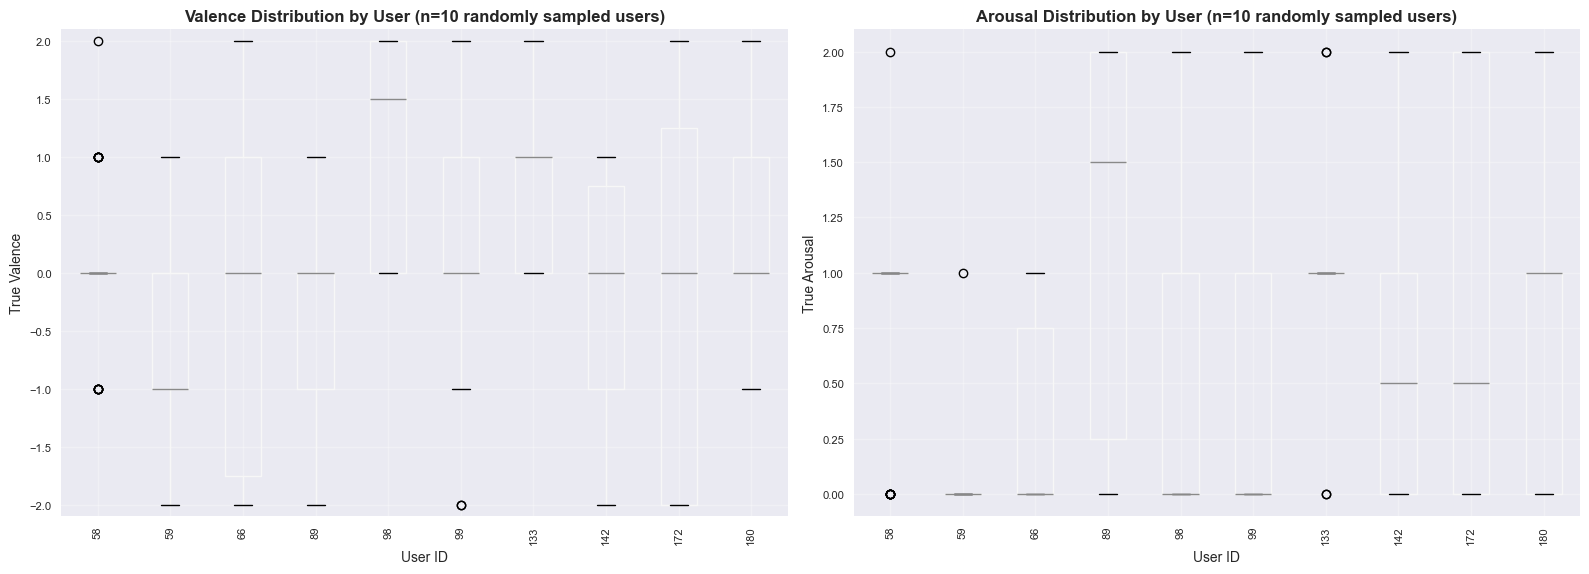

Saved user-wise boxplot to plots/user_wise_boxplot.png


In [15]:
# Randomly sample 20-30 users
n_users_to_plot = min(10, df_filtered['user_id'].nunique())
sampled_users = np.random.choice(df_filtered['user_id'].unique(), size=n_users_to_plot, replace=False)
df_sampled = df_filtered[df_filtered['user_id'].isin(sampled_users)].copy()

# Sort by user_id for better visualization
df_sampled = df_sampled.sort_values('user_id')

# Create boxplots for valence
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Valence boxplot
ax1 = axes[0]
df_sampled.boxplot(column='valence', by='user_id', ax=ax1, rot=90, fontsize=8)
ax1.set_title(f'Valence Distribution by User (n={n_users_to_plot} randomly sampled users)', fontsize=12, fontweight='bold')
ax1.set_xlabel('User ID', fontsize=10)
ax1.set_ylabel('True Valence', fontsize=10)
ax1.set_ylim(df_filtered['valence'].min() - 0.1, df_filtered['valence'].max() + 0.1)
plt.suptitle('')  # Remove default title
ax1.grid(True, alpha=0.3)

# Arousal boxplot
ax2 = axes[1]
df_sampled.boxplot(column='arousal', by='user_id', ax=ax2, rot=90, fontsize=8)
ax2.set_title(f'Arousal Distribution by User (n={n_users_to_plot} randomly sampled users)', fontsize=12, fontweight='bold')
ax2.set_xlabel('User ID', fontsize=10)
ax2.set_ylabel('True Arousal', fontsize=10)
ax2.set_ylim(df_filtered['arousal'].min() - 0.1, df_filtered['arousal'].max() + 0.1)
plt.suptitle('')  # Remove default title
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/user_wise_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved user-wise boxplot to plots/user_wise_boxplot.png")


## Plot 2: Variance Comparison Bar Plot


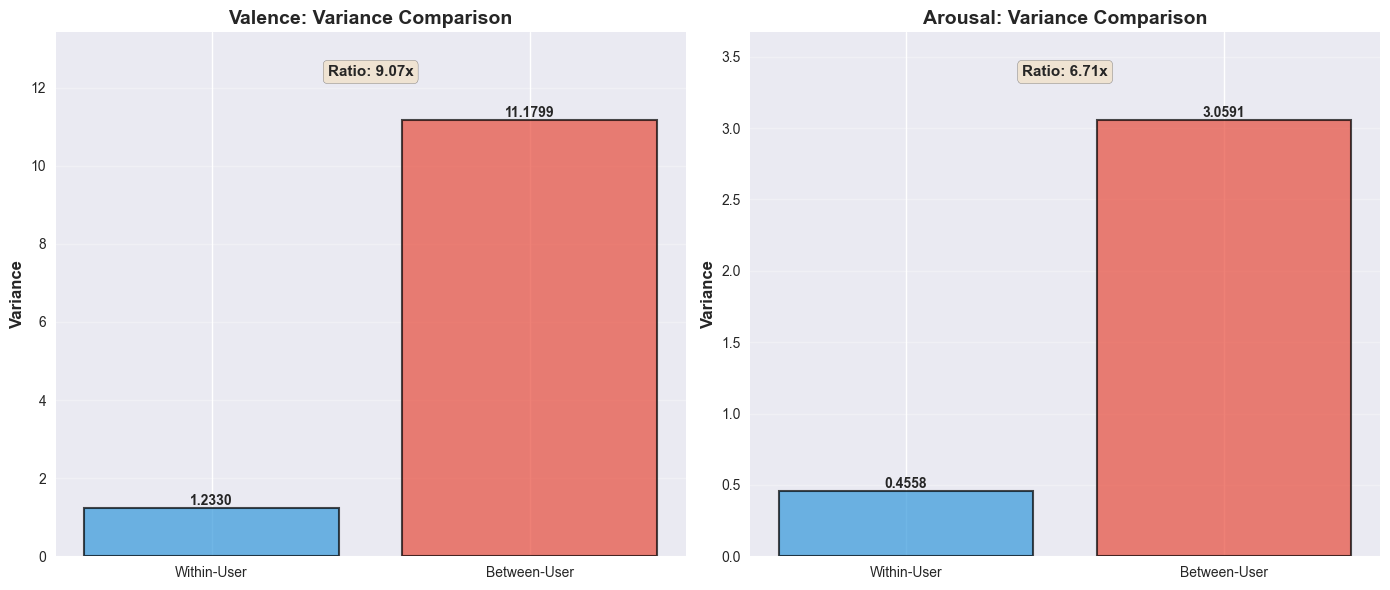

Saved variance comparison plot to plots/variance_comparison.png


In [13]:
# Prepare data for bar plot
variance_data = {
    'Type': ['Within-User', 'Between-User', 'Within-User', 'Between-User'],
    'Variance': [
        valence_results['ms_within'],
        valence_results['ms_between'],
        arousal_results['ms_within'],
        arousal_results['ms_between']
    ],
    'Target': ['Valence', 'Valence', 'Arousal', 'Arousal']
}

variance_df = pd.DataFrame(variance_data)

# Create bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Valence variance comparison
ax1 = axes[0]
valence_vars = ['Within-User', 'Between-User']
valence_values = [valence_results['ms_within'], valence_results['ms_between']]
colors = ['#3498db', '#e74c3c']
bars1 = ax1.bar(valence_vars, valence_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Variance', fontsize=12, fontweight='bold')
ax1.set_title('Valence: Variance Comparison', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(valence_values) * 1.2)

# Add value labels on bars
for bar, val in zip(bars1, valence_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add ratio text
ratio_v = valence_results['ms_between'] / valence_results['ms_within']
ax1.text(0.5, max(valence_values) * 1.1, f'Ratio: {ratio_v:.2f}x', 
         ha='center', fontsize=11, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Arousal variance comparison
ax2 = axes[1]
arousal_vars = ['Within-User', 'Between-User']
arousal_values = [arousal_results['ms_within'], arousal_results['ms_between']]
bars2 = ax2.bar(arousal_vars, arousal_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Variance', fontsize=12, fontweight='bold')
ax2.set_title('Arousal: Variance Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, max(arousal_values) * 1.2)

# Add value labels on bars
for bar, val in zip(bars2, arousal_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add ratio text
ratio_a = arousal_results['ms_between'] / arousal_results['ms_within']
ax2.text(0.5, max(arousal_values) * 1.1, f'Ratio: {ratio_a:.2f}x', 
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('plots/variance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved variance comparison plot to plots/variance_comparison.png")


In [14]:
# Create summary table
summary_data = {
    'Target': ['Valence', 'Arousal'],
    'F-statistic': [valence_results['f_statistic'], arousal_results['f_statistic']],
    'p-value': [valence_results['p_value'], arousal_results['p_value']],
    'η² (eta-squared)': [valence_results['eta_squared'], arousal_results['eta_squared']],
    'Mean Within-User Variance': [valence_results['ms_within'], arousal_results['ms_within']],
    'Mean Between-User Variance': [valence_results['ms_between'], arousal_results['ms_between']],
    'Ratio (Between/Within)': [
        valence_results['ms_between'] / valence_results['ms_within'],
        arousal_results['ms_between'] / arousal_results['ms_within']
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)
print(summary_df.to_string(index=False))
print("\n")

# Save to CSV
summary_df.to_csv('anova_summary.csv', index=False)
print("Saved summary table to anova_summary.csv")



SUMMARY TABLE
 Target  F-statistic       p-value  η² (eta-squared)  Mean Within-User Variance  Mean Between-User Variance  Ratio (Between/Within)
Valence     9.067033 1.898836e-123          0.292093                   1.233024                   11.179872                9.067033
Arousal     6.710731  1.431017e-84          0.233943                   0.455847                    3.059068                6.710731


Saved summary table to anova_summary.csv
